In [1]:
import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile


# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [4]:
for dirpath, dirnames, filenames in os.walk("/content/UTKFace"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 0 directories and 23708 images in '/content/UTKFace'.


In [5]:
for dirpath, dirnames, filenames in os.walk("/content/crop_part1"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 0 directories and 9780 images in '/content/crop_part1'.


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 4)

  # Read in the image and plot it using matplotlib
  fig, ax = plt.subplots(2,2)
  for i in range(4):
    img = mpimg.imread(target_folder + "/" + random_image[i])
    if(i<=1):
      ax[0][i].imshow(img)
      ax[0][i].set_title(random_image[i].split('.')[0])
      print(img.shape)
    else:
      ax[1][i-2].imshow(img)
      ax[1][i-2].set_title(random_image[i].split('.')[0])
      print(img.shape)

(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


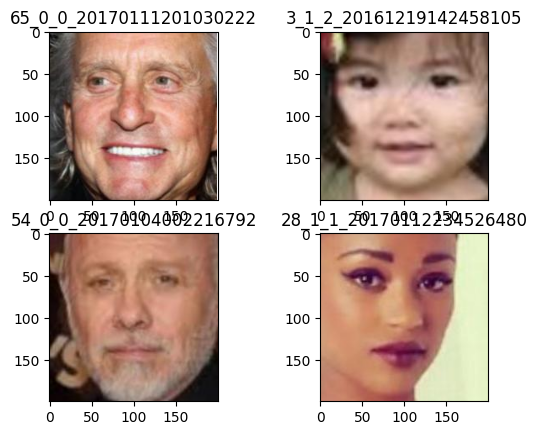

In [7]:
view_random_image('/content/UTKFace')

In [8]:
image_paths = []
age_labels = []
gender_labels = []
gender_age_labels = []

for filename in os.listdir("/content/UTKFace"):
    image_path = os.path.join("/content/UTKFace", filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    gender_age_labels.append([gender, age])

In [9]:
image_paths[:2]

['/content/UTKFace/29_1_1_20170116231359922.jpg.chip.jpg',
 '/content/UTKFace/23_0_4_20170117194059597.jpg.chip.jpg']

In [10]:
age_labels[:10]

[29, 23, 29, 31, 16, 52, 66, 62, 20, 26]

In [11]:
gender_labels[:10]

[1, 0, 0, 0, 1, 0, 0, 0, 1, 1]

In [12]:
gender_age_labels[:10]

[[1, 29],
 [0, 23],
 [0, 29],
 [0, 31],
 [1, 16],
 [0, 52],
 [0, 66],
 [0, 62],
 [1, 20],
 [1, 26]]

In [13]:
import numpy as np

In [14]:
def split_data(images, labels, train_size=0.6, validation_size=0.2, shuffle=True):
    np.random.seed(42)
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the sizes of training, validation, and test samples
    train_samples = int(size * train_size)
    validation_samples = int(size * validation_size)
    # 4. Split data into training, validation, and test sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:(train_samples + validation_samples)]], labels[indices[train_samples:(train_samples + validation_samples)]]
    x_test, y_test = images[indices[(train_samples + validation_samples):]], labels[indices[(train_samples + validation_samples):]]
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [15]:
# Splitting data into training, validation, and test sets
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(image_paths), np.array(gender_age_labels), train_size=0.6, validation_size=0.2)

In [16]:
import tensorflow as tf

In [20]:
def preprocess_image(image, target_size=(200, 200)):
    # Normalize pixel values to range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Resize the image
    image = tf.image.resize(image, target_size)

    # Convert to grayscale
    # image = tf.image.rgb_to_grayscale(image)

    # Remove blurriness and noise using Gaussian blur
    image = tf.image.random_brightness(image, max_delta=0.5)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)  # Adjust contrast

    return image

def preprocess_data(image_path, gender_age_label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = preprocess_image(image)
    gender_label = gender_age_label[0]  # Extract gender label
    age_label = gender_age_label[1]     # Extract age label
    return image, (gender_label, age_label)


# def load_and_preprocess_image(image_path, label):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG images
#     image = preprocess_image(image)  # Preprocess the image
#     return image, label

In [21]:

batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [24]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False)
base_model.trainable = False

In [25]:
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Dropout, Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

input_size = (200, 200, 3)
inputs = Input(shape=input_size)
X = base_model(inputs,training=False)
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer=glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis=3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu')(X)
dense_3 = Dense(128, activation='relu')(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)

# Gender output
output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)

# Age output
output_age = Dense(1, activation='linear', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_gender, output_age])


In [26]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "drive/MyDrive/model_3_weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    monitor='val_age_output_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [28]:
history = model.fit(train_dataset, batch_size = 32, epochs=15, validation_data = validation_dataset, callbacks=[checkpoint_callback])

Epoch 1/15
445/445 [==============================] - ETA: 0s - loss: 16.6046 - gender_output_loss: 0.6735 - age_output_loss: 15.9311 - gender_output_accuracy: 0.6585 - age_output_accuracy: 0.0461
Epoch 1: val_age_output_loss improved from inf to 18.03155, saving model to drive/MyDrive/model_3_weights.h5
445/445 [==============================] - 48s 87ms/step - loss: 16.6046 - gender_output_loss: 0.6735 - age_output_loss: 15.9311 - gender_output_accuracy: 0.6585 - age_output_accuracy: 0.0461 - val_loss: 18.5907 - val_gender_output_loss: 0.5591 - val_age_output_loss: 18.0315 - val_gender_output_accuracy: 0.7585 - val_age_output_accuracy: 0.0430
Epoch 2/15
444/445 [============================>.] - ETA: 0s - loss: 13.0142 - gender_output_loss: 0.4937 - age_output_loss: 12.5205 - gender_output_accuracy: 0.7457 - age_output_accuracy: 0.0395
Epoch 2: val_age_output_loss improved from 18.03155 to 10.72436, saving model to drive/MyDrive/model_3_weights.h5
445/445 [===========================

In [29]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [30]:
model.compile(loss=['binary_crossentropy','mae'], optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [31]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_3 True
conv2d True
batch_normalization True
max_pooling2d True
conv2d_1 True
max_pooling2d_1 True
conv2d_2 True
max_pooling2d_2 True
flatten True
dense_1 True
dense True
dense_2 True
dropout True
dropout_1 True
gender_output True
age_output True


In [32]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block1c_dwconv False
31 block1c_bn False
32 block1c_activation False
33 block1c_se_squeeze False
34 block1c_se_reshape False
35 block1c_se_reduce False
36 block1c_se_expand False
37 block1c_se_excite False
38 block1c_project_conv False
39 block1c_project_bn Fals

In [33]:
fine_tune_epochs = 10

In [34]:
history = model.fit(train_dataset, batch_size = 32, epochs=fine_tune_epochs, validation_data = validation_dataset, callbacks=[checkpoint_callback])

Epoch 1/10
444/445 [============================>.] - ETA: 0s - loss: 7.1324 - gender_output_loss: 0.2672 - age_output_loss: 6.8651 - gender_output_accuracy: 0.8676 - age_output_accuracy: 0.0461
Epoch 1: val_age_output_loss improved from 7.66752 to 6.78180, saving model to drive/MyDrive/model_3_weights.h5
445/445 [==============================] - 41s 86ms/step - loss: 7.1321 - gender_output_loss: 0.2672 - age_output_loss: 6.8648 - gender_output_accuracy: 0.8675 - age_output_accuracy: 0.0463 - val_loss: 7.0881 - val_gender_output_loss: 0.3063 - val_age_output_loss: 6.7818 - val_gender_output_accuracy: 0.8760 - val_age_output_accuracy: 0.0445
Epoch 2/10
444/445 [============================>.] - ETA: 0s - loss: 6.9628 - gender_output_loss: 0.2647 - age_output_loss: 6.6981 - gender_output_accuracy: 0.8718 - age_output_accuracy: 0.0470
Epoch 2: val_age_output_loss did not improve from 6.78180
445/445 [==============================] - 35s 80ms/step - loss: 6.9590 - gender_output_loss: 0.2

In [35]:
true_gender_labels = y_test[:,0]
true_age_labels = y_test[:,1]

In [36]:
from sklearn.metrics import mean_absolute_error, accuracy_score

def evaluate(model, dataset, y_true_age, y_true_gender):
    age_predictions = []

    # for batch in dataset:
    #   preds = model.predict(batch)
    #   age_predictions.extend(preds[1].reshape(-1))

    # preds = model.predict(dataset)
    # for i in range(len(dataset)):
    #   batch_preds = preds[i]
    #   age_predictions.extend(batch_preds[1].reshape(-1))

    preds = model.predict(dataset)

    # Extend age_predictions with the predictions for age
    age_predictions = preds[1].reshape(-1)

    gender_predictions = preds[0].reshape(-1)
    gender_predictions = [1 if pred>=0.5 else 0 for pred in gender_predictions]
    mae = mean_absolute_error(y_true_age, age_predictions)
    acc = accuracy_score(y_true_gender, gender_predictions)

    return {"Age_Prediction_MAE" : mae, "Gender_Prediction_Accuracy" : acc}



In [40]:
import pandas as pd
evaluate(model, test_dataset, np.array(true_age_labels), np.array(true_gender_labels))

149/149 [==============================] - 3s 20ms/step


{'Age_Prediction_MAE': 6.798200798152797,
 'Gender_Prediction_Accuracy': 0.8745519713261649}

In [44]:
from tensorflow.keras.models import load_model
model.load_weights("drive/MyDrive/model_3_weights.h5")

In [45]:
evaluate(model, test_dataset, np.array(true_age_labels), np.array(true_gender_labels))

149/149 [==============================] - 4s 27ms/step


{'Age_Prediction_MAE': 6.821651506330955,
 'Gender_Prediction_Accuracy': 0.8747628083491461}

In [46]:
history = model.fit(train_dataset, batch_size = 32, epochs=fine_tune_epochs, validation_data = validation_dataset, callbacks=[checkpoint_callback])

Epoch 1/10
444/445 [============================>.] - ETA: 0s - loss: 6.5910 - gender_output_loss: 0.2454 - age_output_loss: 6.3455 - gender_output_accuracy: 0.8801 - age_output_accuracy: 0.0470
Epoch 1: val_age_output_loss did not improve from 6.55019
445/445 [==============================] - 37s 84ms/step - loss: 6.5893 - gender_output_loss: 0.2455 - age_output_loss: 6.3438 - gender_output_accuracy: 0.8799 - age_output_accuracy: 0.0472 - val_loss: 6.8538 - val_gender_output_loss: 0.3021 - val_age_output_loss: 6.5517 - val_gender_output_accuracy: 0.8741 - val_age_output_accuracy: 0.0445
Epoch 2/10
444/445 [============================>.] - ETA: 0s - loss: 6.6418 - gender_output_loss: 0.2473 - age_output_loss: 6.3944 - gender_output_accuracy: 0.8778 - age_output_accuracy: 0.0467
Epoch 2: val_age_output_loss did not improve from 6.55019
445/445 [==============================] - 35s 79ms/step - loss: 6.6379 - gender_output_loss: 0.2474 - age_output_loss: 6.3905 - gender_output_accuracy

In [47]:
evaluate(model, test_dataset, np.array(true_age_labels), np.array(true_gender_labels))

149/149 [==============================] - 3s 20ms/step


{'Age_Prediction_MAE': 6.677043762710711,
 'Gender_Prediction_Accuracy': 0.876449504532996}

In [48]:
model.save("utk_mae_66.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
shutil.copy("/content/utk_mae_66.h5","drive/MyDrive/")

'drive/MyDrive/utk_mae_66.h5'